# Import modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Loading Dataset

In [3]:
#loading dataset
data_dir = "generated_images"

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 for CNN
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_dataset

In [4]:
train_size

400

In [5]:
test_size

100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


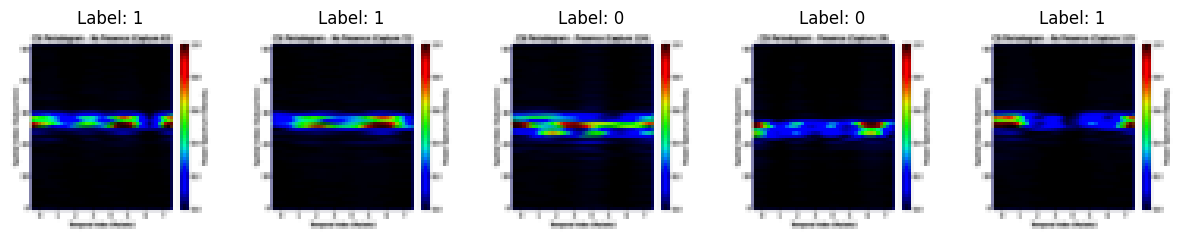

In [6]:
def ipimages(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0))  # Convert from Tensor (C, H, W) to (H, W, C) for display
        axes[i].axis('off')  
        axes[i].set_title(f'Label: {label}')
    plt.show()
ipimages(train_dataset, num_images=5)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['Human_Presence', 'No_Presence']


In [9]:
num_classes

2

## CNN Model

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.fc_layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 16 * 16, num_classes))


    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [11]:
model = CNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training and Testing

In [12]:
num_epochs = 10
train_losses, test_losses = [], []

#trainig
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Test Set
    model.eval()
    test_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    acc = accuracy_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {acc:.4f}")

# Save model
torch.save(model.state_dict(), "cnn_human_presence(train_test).pth")
print("Model saved successfully!")


Epoch [1/10] - Train Loss: 0.8694, Test Loss: 0.5813, Accuracy: 0.4700
Epoch [2/10] - Train Loss: 0.1999, Test Loss: 0.2007, Accuracy: 0.9600
Epoch [3/10] - Train Loss: 0.0755, Test Loss: 0.0706, Accuracy: 0.9800
Epoch [4/10] - Train Loss: 0.0314, Test Loss: 0.0256, Accuracy: 1.0000
Epoch [5/10] - Train Loss: 0.0140, Test Loss: 0.0138, Accuracy: 1.0000
Epoch [6/10] - Train Loss: 0.0071, Test Loss: 0.0072, Accuracy: 1.0000
Epoch [7/10] - Train Loss: 0.0045, Test Loss: 0.0032, Accuracy: 1.0000
Epoch [8/10] - Train Loss: 0.0026, Test Loss: 0.0022, Accuracy: 1.0000
Epoch [9/10] - Train Loss: 0.0021, Test Loss: 0.0014, Accuracy: 1.0000
Epoch [10/10] - Train Loss: 0.0011, Test Loss: 0.0015, Accuracy: 1.0000
Model saved successfully!


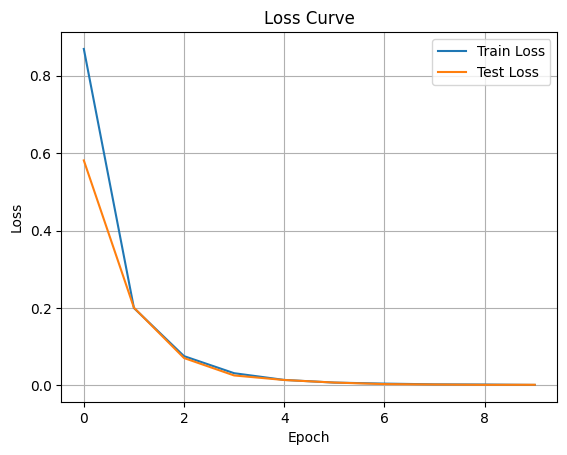

In [13]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.title("Loss Curve")
plt.show()

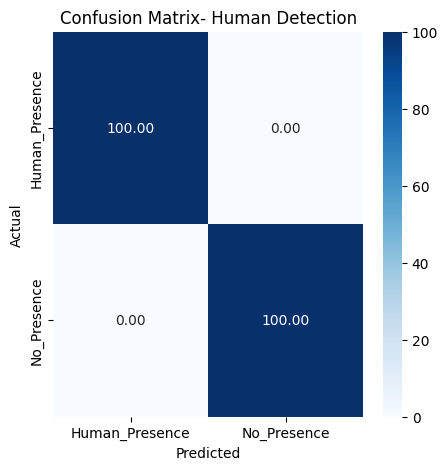

In [14]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix- Human Detection")
plt.show()